<a href="https://colab.research.google.com/github/SabrineAmri/IVADO-DL101/blob/master/site/en/guide/data_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Better performance with the tf.data API

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/data_performance"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

GPUs and TPUs can radically reduce the time required to execute a single training step.
Achieving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished.
The `tf.data` API helps to build flexible and efficient input pipelines.
This document demonstrates how to use the `tf.data` API to build highly performant TensorFlow input pipelines.

Before you continue, check the [Build TensorFlow input pipelines](./data.ipynb) guide to learn how to use the `tf.data` API.

## Resources

* [Build TensorFlow input pipelines](./data.ipynb)
* `tf.data.Dataset` API
* [Analyze `tf.data` performance with the TF Profiler](./data_performance_analysis.md)

## Setup

In [1]:
import tensorflow as tf

import time

Throughout this guide, you will iterate across a dataset and measure the performance.
Making reproducible performance benchmarks can be difficult. Different factors affecting reproducibility include:

- The current CPU load
- The network traffic
- Complex mechanisms, such as cache

To get a reproducible benchmark, you will build an artificial example.

### The dataset

Start with defining a class inheriting from `tf.data.Dataset` called `ArtificialDataset`.
This dataset:

- Generates `num_samples` samples (default is 3)
- Sleeps for some time before the first item to simulate opening a file
- Sleeps for some time before producing each item to simulate reading data from a file

In [2]:
class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        # Opening the file
        time.sleep(0.03)

        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            time.sleep(0.015)

            yield (sample_idx,)

    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature = tf.TensorSpec(shape = (1,), dtype = tf.int64),
            args=(num_samples,)
        )

This dataset is similar to the `tf.data.Dataset.range` one, adding a fixed delay at the beginning of and in-between each sample.

### The training loop

Next, write a dummy training loop that measures how long it takes to iterate over a dataset.
Training time is simulated.

In [3]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

## Optimize performance

To exhibit how performance can be optimized, you will improve the performance of the `ArtificialDataset`.

### The naive approach

Start with a naive pipeline using no tricks, iterating over the dataset as-is.

In [4]:
benchmark(ArtificialDataset())

Execution time: 0.3042940180000073


Under the hood, this is how your execution time was spent:

![Data execution time plot - a naive method](https://www.tensorflow.org/guide/images/data_performance/naive.svg)

The plot shows that performing a training step involves:

- Opening a file if it hasn't been opened yet
- Fetching a data entry from the file
- Using the data for training

However, in a naive synchronous implementation like here, while your pipeline is fetching the data, your model is sitting idle.
Conversely, while your model is training, the input pipeline is sitting idle.
The training step time is thus the sum of opening, reading and training times.

The next sections build on this input pipeline, illustrating best practices for designing performant TensorFlow input pipelines.

### Prefetching

<a name="prefetching"></a>

Prefetching overlaps the preprocessing and model execution of a training step.
While the model is executing training step `s`, the input pipeline is reading the data for step `s+1`.
Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

The `tf.data` API provides the `tf.data.Dataset.prefetch` transformation.
It can be used to decouple the time when data is produced from the time when data is consumed.
In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested.
The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step.
You could either manually tune this value, or set it to `tf.data.AUTOTUNE`, which will prompt the
`tf.data` runtime to tune the value dynamically at runtime.

Note that the prefetch transformation provides benefits any time there is an opportunity to overlap the work of a "producer" with the work of a "consumer."

In [5]:
benchmark(
    ArtificialDataset()
    .prefetch(tf.data.AUTOTUNE)
)

Execution time: 0.23031097400001954


![Data execution time plot - prefetching method](https://www.tensorflow.org/guide/images/data_performance/prefetched.svg)

Now, as the data execution time plot shows, while the training step is running for sample 0, the input pipeline is reading the data for the sample 1, and so on.

### Parallelizing data extraction

<a name="parallelizing_data_extraction"></a>

In a real-world setting, the input data may be stored remotely (for example, on Google Cloud Storage or HDFS).
A dataset pipeline that works well when reading data locally might become bottlenecked on I/O when reading data remotely because of the following differences between local and remote storage:

- **Time-to-first-byte**: Reading the first byte of a file from remote storage can take orders of magnitude longer than from local storage.
- **Read throughput**: While remote storage typically offers large aggregate bandwidth, reading a single file might only be able to utilize a small fraction of this bandwidth.

In addition, once the raw bytes are loaded into memory, it may also be necessary to deserialize and/or decrypt the data (e.g. [protobuf](https://developers.google.com/protocol-buffers/)), which requires additional computation.
This overhead is present irrespective of whether the data is stored locally or remotely, but can be worse in the remote case if data is not prefetched effectively.

To mitigate the impact of the various data extraction overheads, the `tf.data.Dataset.interleave` transformation can be used to parallelize the data loading step, interleaving the contents of other datasets (such as data file
readers).
The number of datasets to overlap can be specified by the `cycle_length` argument, while the level of parallelism can be specified by the `num_parallel_calls` argument. Similar to the `prefetch` transformation, the `interleave` transformation supports `tf.data.AUTOTUNE`, which will delegate the decision about what level of parallelism to use to the `tf.data` runtime.

#### Sequential interleave

The default arguments of the `tf.data.Dataset.interleave` transformation make it interleave single samples from two datasets sequentially.

In [6]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(lambda _: ArtificialDataset())
)

Execution time: 0.4125355129999946


![Data execution time plot - sequential interleave](https://www.tensorflow.org/guide/images/data_performance/sequential_interleave.svg)

This data execution time plot allows to exhibit the behavior of the `interleave` transformation, fetching samples alternatively from the two datasets available.
However, no performance improvement is involved here.

#### Parallel interleave

Now, use the `num_parallel_calls` argument of the `interleave` transformation.
This loads multiple datasets in parallel, reducing the time waiting for the files to be opened.

In [8]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        lambda _: ArtificialDataset(),
        num_parallel_calls=tf.data.AUTOTUNE
    )
)

Execution time: 0.33515903100001765


![Data execution time plot - parallel interleave method](https://www.tensorflow.org/guide/images/data_performance/parallel_interleave.svg)

This time, as the data execution time plot shows, the reading of the two datasets is parallelized, reducing the global data processing time.

### Parallelizing data transformation

<a name="parallelizing_data_transformation"></a>

When preparing data, input elements may need to be pre-processed.
To this end, the `tf.data` API offers the `tf.data.Dataset.map` transformation, which applies a user-defined function to each element of the input dataset.
Because input elements are independent of one another, the pre-processing can be parallelized across multiple CPU cores.
To make this possible, similarly to the `prefetch` and `interleave` transformations, the `map` transformation provides the `num_parallel_calls` argument to specify the level of parallelism.

Choosing the best value for the `num_parallel_calls` argument depends on your hardware, characteristics of your training data (such as its size and shape), the cost of your map function, and what other processing is happening on the CPU at the same time.
A simple heuristic is to use the number of available CPU cores.
However, as for the `prefetch` and `interleave` transformation, the `map` transformation supports `tf.data.AUTOTUNE` which will delegate the decision about what level of parallelism to use to the `tf.data` runtime.

In [9]:
def mapped_function(s):
    # Do some hard pre-processing
    tf.py_function(lambda: time.sleep(0.03), [], ())
    return s

#### Sequential mapping

Start by using the `map` transformation without parallelism as a baseline example.

In [10]:
benchmark(
    ArtificialDataset()
    .map(mapped_function)
)

Execution time: 0.4181898489999867


![Data execution time plot - sequential mapping method](https://www.tensorflow.org/guide/images/data_performance/sequential_map.svg)

As for the [naive approach](#The-naive-approach), here, as the plot shows, the times spent for opening, reading, pre-processing (mapping) and training steps sum together for a single iteration.

#### Parallel mapping

Now, use the same pre-processing function but apply it in parallel on multiple samples.

In [11]:
benchmark(
    ArtificialDataset()
    .map(
        mapped_function,
        num_parallel_calls=tf.data.AUTOTUNE
    )
)

Execution time: 0.48636432999998647


![Data execution time - parallel mapping](https://www.tensorflow.org/guide/images/data_performance/parallel_map.svg)

As the data plot demonstrates, the pre-processing steps overlap, reducing the overall time for a single iteration.

### Caching

<a name="caching"></a>

The `tf.data.Dataset.cache` transformation can cache a dataset, either in memory or on local storage.
This will save some operations (like file opening and data reading) from being executed during each epoch.

In [12]:
benchmark(
    ArtificialDataset()
    .map(  # Apply time consuming operations before cache
        mapped_function
    ).cache(
    ),
    5
)

Execution time: 0.38624584900000514


![Data execution time - cached dataset method](https://www.tensorflow.org/guide/images/data_performance/cached_dataset.svg)

Here, the data execution time plot shows that when you cache a dataset, the transformations before the `cache` one (like the file opening and data reading) are executed only during the first epoch.
The next epochs will reuse the data cached by the`cache` transformation.

If the user-defined function passed into the `map` transformation is expensive, apply the `cache` transformation after the `map` transformation as long as the resulting dataset can still fit into memory or local storage.
If the user-defined function increases the space required to store the dataset beyond the cache capacity, either apply it after the `cache` transformation or consider pre-processing your data before your training job to reduce resource usage.

### Vectorizing mapping

<a name="vectorizing_mapping"></a>

Invoking a user-defined function passed into the `map` transformation has overhead related to scheduling and executing the user-defined function.
Vectorize the user-defined function (that is, have it operate over a batch of inputs at once) and apply the `batch` transformation _before_ the `map` transformation.

To illustrate this good practice, your artificial dataset is not suitable.
The scheduling delay is around 10 microseconds (10e-6 seconds), far less than the tens of milliseconds used in the `ArtificialDataset`, and thus its impact is hard to see.

For this example, use the base `tf.data.Dataset.range` function and simplify the training loop to its simplest form.

In [13]:
fast_dataset = tf.data.Dataset.range(10000)

def fast_benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for _ in tf.data.Dataset.range(num_epochs):
        for _ in dataset:
            pass
    tf.print("Execution time:", time.perf_counter() - start_time)

def increment(x):
    return x+1

#### Scalar mapping

In [14]:
fast_benchmark(
    fast_dataset
    # Apply function one item at a time
    .map(increment)
    # Batch
    .batch(256)
)

Execution time: 0.6259479539999973


![Data execution time - scalar map method](https://www.tensorflow.org/guide/images/data_performance/scalar_map.svg)

The plot above illustrates what is going on (with less samples) using the scalar mapping method.
It shows that the mapped function is applied for each sample.
While this function is very fast, it has some overhead that impact the time performance.

#### Vectorized mapping

In [15]:
fast_benchmark(
    fast_dataset
    .batch(256)
    # Apply function on a batch of items
    # The tf.Tensor.__add__ method already handle batches
    .map(increment)
)

Execution time: 0.1064976429999831


![Data execution time - vectorized map method](https://www.tensorflow.org/guide/images/data_performance/vectorized_map.svg)

This time, the mapped function is called once and applies to a batch of sample.
As the data execution time plot shows, while the function could takes more time to execute, the overhead appear only once, improving the overall time performance.

### Reducing memory footprint

<a name="reducing_memory_footprint"></a>

A number of transformations, including `interleave`, `prefetch`, and `shuffle`, maintain an internal buffer of elements. If the user-defined function passed into the `map` transformation changes the size of the elements, then the ordering of the map transformation and the transformations that buffer elements affects the memory usage. In general, choose the order that results in lower memory footprint, unless different ordering is desirable for performance.

#### Caching partial computations

It is recommended to cache the dataset after the `map` transformation except if this transformation makes the data too big to fit in memory.
A trade-off can be achieved if your mapped function can be split in two parts: a time consuming one and a memory consuming part.
In this case, you can chain your transformations like below:

```python
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
```

This way, the time consuming part is only executed during the first epoch, and you avoid using too much cache space.

## Best practice summary

Here is a summary of the best practices for designing performant TensorFlow
input pipelines:

*   [Use the `prefetch` transformation](#prefetching) to overlap the work of a producer and consumer
*   [Parallelize the data reading transformation](#parallelizing_data_extraction) using the `interleave` transformation
*   [Parallelize the `map` transformation](#parallelizing_data_transformation) by setting the `num_parallel_calls` argument
*   [Use the `cache` transformation](#caching) to cache data in memory during the first epoch
*   [Vectorize user-defined functions](#vectorizing_mapping) passed in to the `map` transformation
*   [Reduce memory usage](#reducing_memory_footprint) when applying the `interleave`, `prefetch`, and `shuffle` transformations

## Reproducing the figures

Note: The rest of this notebook is about how to reproduce the above figures. Feel free to play around with this code, but understanding it is not an essential part of this tutorial.

To go deeper in the `tf.data.Dataset` API understanding, you can play with your own pipelines.
Below is the code used to plot the images from this guide.
It can be a good starting point, showing some workarounds for common difficulties such as:

- Execution time reproducibility
- Mapped functions eager execution
- `interleave` transformation callable

In [16]:
import itertools
from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### The dataset

Similar to the `ArtificialDataset` you can build a dataset returning the time spent in each step.

In [17]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters)
    OUTPUT_TYPES = (tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32)
    OUTPUT_SHAPES = ((2, 1), (2, 2), (2, 3))

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, num_samples):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        time.sleep(0.03)
        open_elapsed = time.perf_counter() - open_enter

        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            time.sleep(0.015)
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(next(cls._INSTANCES_COUNTER), num_samples)
        )

This dataset provides samples of shape `[[2, 1], [2, 2], [2, 3]]` and of type `[tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32]`.
Each sample is:
```
(
  [("Open"), ("Read")],
  [(t0, d), (t0, d)],
  [(i, e, -1), (i, e, s)]
)
```

Where:

- `Open` and `Read` are steps identifiers
- `t0` is the timestamp when the corresponding step started
- `d` is the time spent in the corresponding step
- `i` is the instance index
- `e` is the epoch index (number of times the dataset has been iterated)
- `s` is the sample index

### The iteration loop

Make the iteration loop a little bit more complicated to aggregate all timings.
This will only work with datasets generating samples as detailed above.

In [18]:
def timelined_benchmark(dataset, num_epochs=2):
    # Initialize accumulators
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        epoch_enter = time.perf_counter()
        for (steps, times, values) in dataset:
            # Record dataset preparation informations
            steps_acc = tf.concat((steps_acc, steps), axis=0)
            times_acc = tf.concat((times_acc, times), axis=0)
            values_acc = tf.concat((values_acc, values), axis=0)

            # Simulate training time
            train_enter = time.perf_counter()
            time.sleep(0.01)
            train_elapsed = time.perf_counter() - train_enter

            # Record training informations
            steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
            times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
            values_acc = tf.concat((values_acc, [values[-1]]), axis=0)

        epoch_elapsed = time.perf_counter() - epoch_enter
        # Record epoch informations
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch_num, -1]]), axis=0)
        time.sleep(0.001)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

### The plotting method

Finally, define a function able to plot a timeline given the values returned by the `timelined_benchmark` function.

In [19]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()

    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)

    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)

    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")

        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]

        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

### Use wrappers for mapped function

To run mapped function in an eager context, you have to wrap them inside a `tf.py_function` call.

In [20]:
def map_decorator(func):
    def wrapper(steps, times, values):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values),
            Tout=(steps.dtype, times.dtype, values.dtype)
        )
    return wrapper

### Pipelines comparison

In [21]:
_batch_map_num_items = 50

def dataset_generator_fun(*args):
    return TimeMeasuredDataset(num_samples=_batch_map_num_items)

#### Naive

In [22]:
@map_decorator
def naive_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001)  # Time consuming step
    time.sleep(0.0001)  # Memory consuming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0)
    )

naive_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .flat_map(dataset_generator_fun)
    .map(naive_map)
    .batch(_batch_map_num_items, drop_remainder=True)
    .unbatch(),
    5
)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


Execution time: 15.83455575100001


### Optimized

In [23]:
@map_decorator
def time_consuming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001 * values.shape[0])  # Time consuming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, tf.tile([[["1st map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


@map_decorator
def memory_consuming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.0001 * values.shape[0])  # Memory consuming step
    map_elapsed = time.perf_counter() - map_enter

    # Use tf.tile to handle batch dimension
    return (
        tf.concat((steps, tf.tile([[["2nd map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


optimized_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .interleave(  # Parallelize data reading
        dataset_generator_fun,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(  # Vectorize your mapped function
        _batch_map_num_items,
        drop_remainder=True)
    .map(  # Parallelize map transformation
        time_consuming_map,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .cache()  # Cache data
    .map(  # Reduce memory usage
        memory_consuming_map,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .prefetch(  # Overlap producer and consumer works
        tf.data.AUTOTUNE
    )
    .unbatch(),
    5
)

Execution time: 10.362975382999991


<ipython-input-19-c2085563342f>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("plasma")


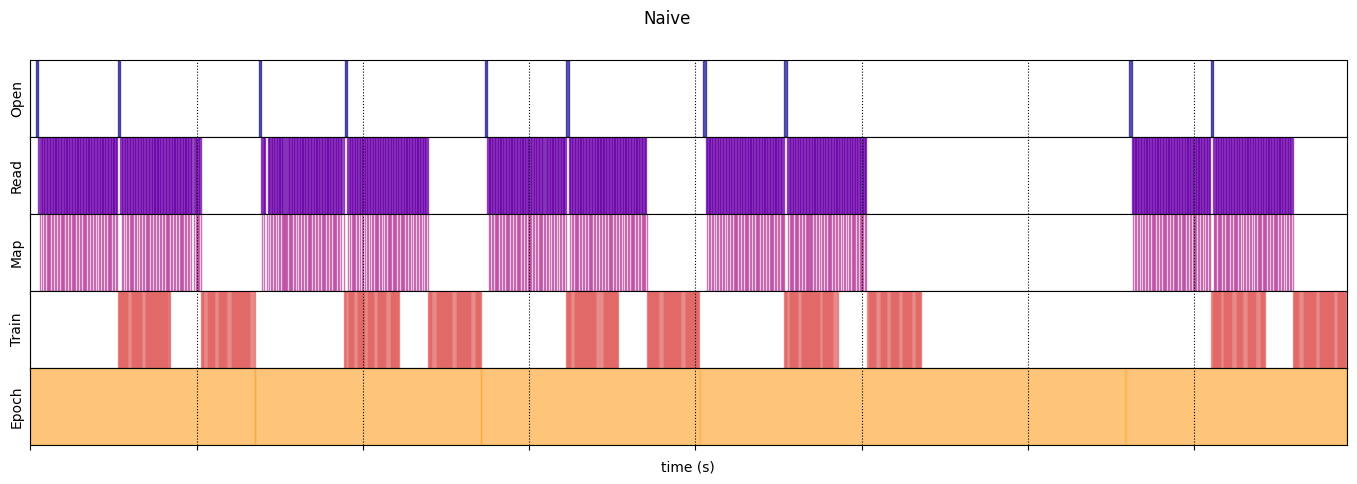

In [24]:
draw_timeline(naive_timeline, "Naive", 15)

<ipython-input-19-c2085563342f>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("plasma")


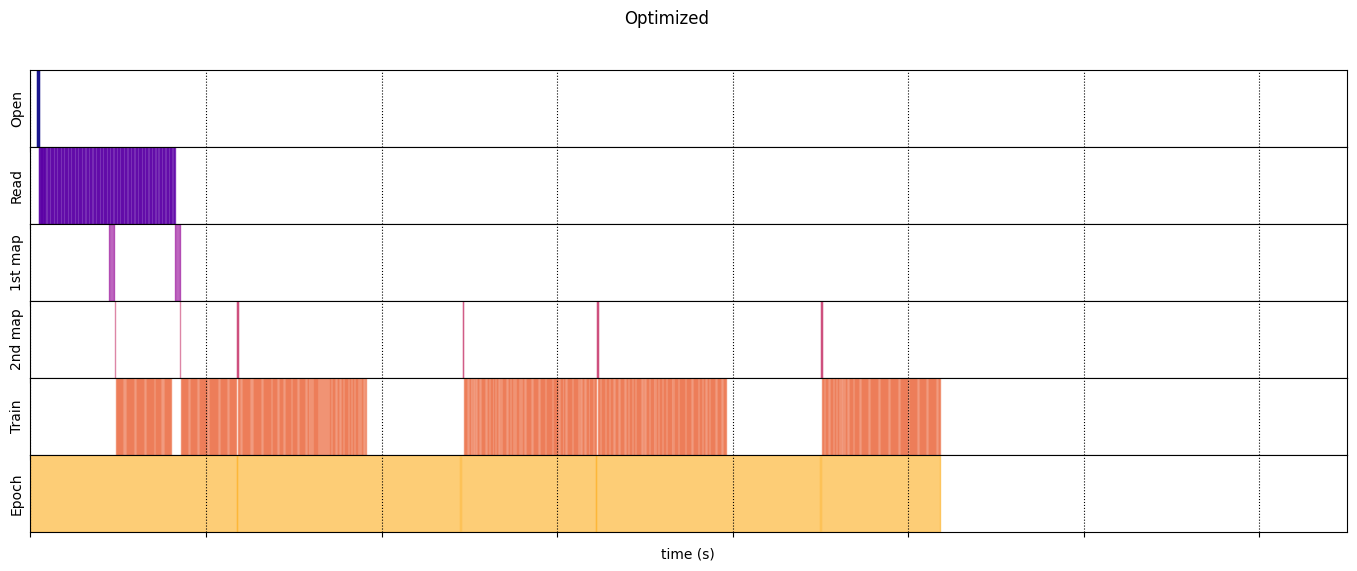

In [25]:
draw_timeline(optimized_timeline, "Optimized", 15)